In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

### Imp note about the dataset:
- The data is only till 2018 as I couldn't find a dataset with data after 2018.
- The original dataset contains prices mentioned in USD*100,as the petrol prices are always known in rupees, later we will convert them to rupees using USD-Rupee conversion.

In [64]:
df1 = pd.read_csv('train_data.csv')
df1.head()

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [65]:
df1.isnull().sum()

Date            0
Petrol (USD)    2
dtype: int64

In [66]:
df1 = df1.dropna()

In [67]:
df1.rename(columns= {"Petrol (USD)":"Petrol"},inplace=True)
df1.head()

,Date,Petrol
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


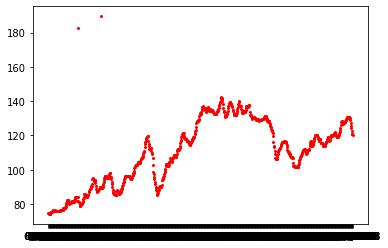

In [68]:
plt.scatter(df1.Date,df1.Petrol,color='red',label='Prices',s=4)

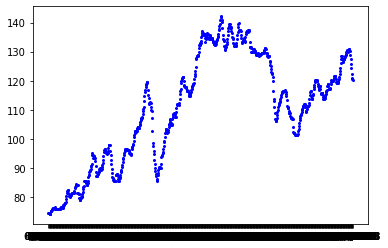

In [69]:
# Rejecting the outliers
df1 = df1[df1.Petrol<160]
plt.scatter(df1.Date,df1.Petrol, color='Blue',label='Prices',s=4)

In [70]:
df1 = df1.reset_index()['Petrol']
df1.head()

0    74.59
1    74.47
2    74.42
3    74.35
4    74.28
Name: Petrol, dtype: float64

Converting into INR

In [71]:
df1 = df1/100*70.696

In [72]:
df1

0      52.732146
1      52.647311
2      52.611963
3      52.562476
4      52.512989
         ...    
804    87.875128
805    86.510695
806    85.556299
807    85.266446
808    84.962453
Name: Petrol, Length: 809, dtype: float64

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [74]:
training_size = int(len(df1)* 0.65)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [75]:
print(f'Training Size: {training_size}, Test Size: {test_size}')

Training Size: 525, Test Size: 284


In [76]:
import numpy as np
# Converting an array of values into a dataset Matrix
def create_dataset(dataset,time_step):
  dataX, dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX) , np.array(dataY)

In [77]:
time_step = 100
X_train , Y_train = create_dataset(train_data,time_step)
X_test, Y_test = create_dataset(test_data,time_step)

In [78]:
print(X_train.shape),print(Y_train.shape)

(424, 100)
(424,)


(None, None)

In [79]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## Using LSTM

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(LSTM(50,return_sequences= True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [81]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 7s 257ms/step - loss: 0.1126 - val_loss: 0.0318
Epoch 2/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0175 - val_loss: 0.0183
Epoch 3/100
7/7 [==============================] - 0s 31ms/step - loss: 0.0151 - val_loss: 0.0133
Epoch 4/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0129 - val_loss: 0.0041
Epoch 5/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0101 - val_loss: 0.0035
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 7/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0069 - val_loss: 0.0033
Epoch 8/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 9/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 10/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 11/100
7/7 [

In [82]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

6/6 [==============================] - 0s 8ms/step


In [83]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

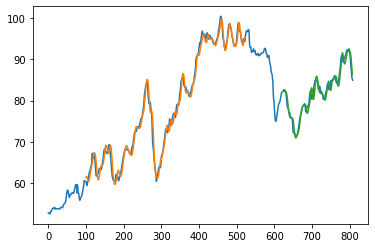

In [84]:
#Plotting
# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Orange part = > Train data 

greeen part = > Test data

Predicting petrol prices for next 30 weeks

In [85]:
len(test_data)

284

In [86]:
x_input = test_data[184:].reshape(1,-1)
x_input.shape

(1, 100)

In [87]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [88]:
from numpy import array

lst_output = []
n_steps = 100
i = 0
while (i<30):
  if (len(temp_input)>100):
    x_input = np.array(temp_input[1:])
    print('{} day input {}'.format(i,x_input))
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))

    yhat = model.predict(x_input,verbose=0)
    print('{} day output {}'.format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    lst_output.extend(yhat.tolist())
    i+=1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i = i+1
  
print(lst_output)

[0.6644069]
101
1 day input [0.67598587 0.6767216  0.67554444 0.67407298 0.67083579 0.65832843
 0.64479105 0.62860506 0.62992937 0.63758093 0.6465568  0.64552678
 0.63051795 0.60903473 0.61006474 0.61183049 0.61227192 0.61035903
 0.60197175 0.59181872 0.58166569 0.57931136 0.58387287 0.58534432
 0.58784579 0.59696881 0.60800471 0.61550912 0.62080636 0.62889935
 0.64640965 0.65685697 0.65715127 0.64626251 0.63198941 0.62978222
 0.63022366 0.63051795 0.63802237 0.65773985 0.6689229  0.67569158
 0.67010006 0.67245438 0.6734844  0.67377869 0.67657446 0.68143025
 0.68790465 0.6958505  0.69864626 0.69923484 0.69702766 0.68143025
 0.66715715 0.66333137 0.66068275 0.66156563 0.6624485  0.66539141
 0.67319011 0.68201883 0.69496763 0.70644497 0.72189523 0.7373455
 0.7610359  0.78531489 0.79782225 0.80047087 0.79031783 0.77942908
 0.77001177 0.77633902 0.78369629 0.78413773 0.78472631 0.79178929
 0.79723367 0.80311948 0.80885815 0.81739258 0.82445556 0.82960565
 0.82960565 0.82062978 0.82313125 0

In [89]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [90]:
len(df1)

809

In [91]:
df2 = df1.tolist()
df2.extend(lst_output)

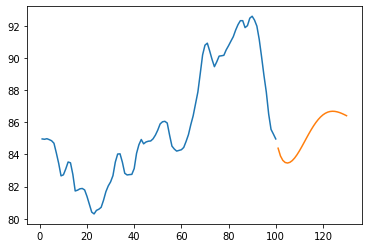

In [92]:
plt.plot(day_new,scaler.inverse_transform(df1[709:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))